# Computer Vision Course #03
## Neural Network, Convolutional Neural Network
by Can Nguyen, Dung Pham - TIC Computer Vision Team



## Introduction
In this practice, you will discover how to develop a deep learning model to achieve a good model for MNIST handwritten digit recognition task in Python using the Keras deep learning library.

After completing this tutorial, you will know:

+ How to load the MNIST dataset in Keras.

+ How to develop and evaluate a baseline neural network model for the MNIST problem.

+ How to implement and evaluate a simple Convolutional Neural Network for MNIST.

Let’s get started.

## Load MNIST dataset

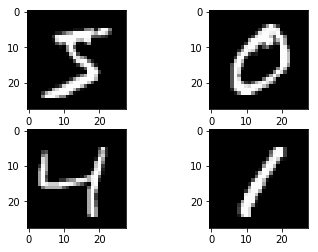

In [2]:

# Plot ad hoc mnist instances
from keras.datasets import mnist
import matplotlib.pyplot as plt
# load (downloaded if needed) the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data(path="mnist.npz")
# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()


## Imports


In [3]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils

 Initialize the random number generator to a constant

In [4]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

Load the MNIST dataset using the Keras helper function

In [5]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

The training dataset is structured as a 3-dimensional array of instance, image width and image height. For a multi-layer perceptron model we must reduce the images down into a vector of pixels. In this case the 28×28 sized images will be 784 pixel input values.

In [6]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

The pixel values are gray scale between 0 and 255. It is almost always a good idea to perform some scaling of input values when using neural network models. Because the scale is well known and well behaved, we can very quickly normalize the pixel values to the range 0 and 1 by dividing each value by the maximum of 255.

In [7]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

the output variable is an integer from 0 to 9. This is a multi-class classification problem. As such, it is good practice to use a one hot encoding of the class values, transforming the vector of class integers into a binary matrix.

We can easily do this using the built-in np_utils.to_categorical() helper function in Keras.

In [8]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

## Create Simple Neural Network Model

We are now ready to create our simple neural network model. We will define our model in a function. This is handy if you want to extend the example later and try and get a better score.

In [9]:
# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
	model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

The model is a simple neural network with one hidden layer with the same number of neurons as there are inputs (784). A rectifier activation function is used for the neurons in the hidden layer.

A softmax activation function is used on the output layer to turn the outputs into probability-like values and allow one class of the 10 to be selected as the model’s output prediction. Logarithmic loss is used as the loss function (called categorical_crossentropy in Keras) and the efficient ADAM gradient descent algorithm is used to learn the weights.

We can now fit and evaluate the model. The model is fit over 10 epochs with updates every 200 images. The test data is used as the validation dataset, allowing you to see the skill of the model as it trains. A verbose value of 2 is used to reduce the output to one line for each training epoch.

Finally, the test dataset is used to evaluate the model and a classification error rate is printed.

In [ ]:
# build the model
model = baseline_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Running the example might take a few minutes when run on a CPU. You should see the output below. This very simple network defined in very few lines of code achieves a respectable error rate of 1.91%.

## Convolution Neural Network

Now that we have seen how to load the MNIST dataset and train a simple multi-layer perceptron model on it, it is time to develop a more sophisticated convolutional neural network or CNN model.

Keras does provide a lot of capability for creating [convolutional neural networks](http://keras.io/layers/convolutional/).

In this section we will create a simple CNN for MNIST that demonstrates how to use all of the aspects of a modern CNN implementation, including Convolutional layers, Pooling layers and Dropout layers.

The first step is to import the classes and functions needed.

In [11]:
# import library
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential,Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from IPython.display import Image
%matplotlib inline

## Load data and show

In [ ]:
# load (downloaded if needed) the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data(path="mnist.npz")
# plot 4 images as gray scale
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(x_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(x_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(x_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(x_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [ ]:
# Shape of X and y label
print("Shape of X :",x_train.shape)
print("Shape of y :",y_train.shape)

## Preprocessing data
Next we need to load the MNIST dataset and reshape it so that it is suitable for use training a CNN. In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [width][height][pixels].

In the case of RGB, the last dimension pixels would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In the case of MNIST where the pixel values are gray scale, the pixel dimension is set to 1.

In [ ]:
# reshape to be [samples][width][height][chanel]
X_train = x_train.reshape(x_train.shape[0], 28, 28,1).astype('float32')
X_test = x_test.reshape(x_test.shape[0],  28, 28,1).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs number class 10
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
# shape of X,y after procesising
print("Shape of X :",X_train.shape)
print("Shape of y :",y_train.shape)

## MNIST CNN ARCHITER
![alt text](mnist.png "Title")

### Parameter of model
* Input shape (28,28,1)
* Convolution 1 : Filter : 32, kernel = 5x5, activation='relu',padding = same ,stride = 1 ==> output (28x28x32)
* Max Pooling 1 : kernel = 2x2, padding = valid,stride = 1 ===> output (14x14x32)
* Convolution 2 : Filter : 64, kernel = 5x5,activation='relu', padding = same ,stride = 1 ==> output (14x14x64)
* Max Pooling 2 : kernel = 2x2, padding = valid,stride = 1 ===> output (7x7x64)
* Flatten : output 7x7x64 =3136
* Dense 1 : hidden size 3136x1024,activation='relu' ===> output 1024
* Dense 2 : hidden size 1024x10,activation='softmax' ====> output  10 # number class :10
* Total parameter : 32x5x5 +32 + 64x5x5x64 + 64 + 3136x1024 + 1024 + 1024x10 + 10 = 3,274,634

## Create model CNN

In [15]:
# Create model 
model = Sequential()
# Add convolution 2D shape (5x5x32),padding same, stride=1)
model.add(Conv2D(32, (5,5),padding="same", input_shape=( 28, 28,1), activation='relu',name="CONV_1"))
# Add Max_pooling 2D kernel size(2,2),no padding, stride=1
model.add(MaxPooling2D(pool_size=(2, 2),name="MAX_POOL_1"))
# Add convolution 2D shape (5x5x64),padding same, stride=1 
model.add(Conv2D(64, (5, 5),padding="same", activation='relu',name="CONV_2"))
# Add Max_pooling 2D kernel size(2,2)
model.add(MaxPooling2D(pool_size=(2, 2),name="MAX_POOL_2"))
# ADD flatten 
model.add(Flatten(name="FLATTEN"))
# ADD dense layer
model.add(Dense(1024, activation='relu',name="Dense_1"))
# ADD dense layer
model.add(Dense(num_classes, activation='softmax',name="Dense_2"))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Summary model
model.summary()

## Training model

In [ ]:
# Fit the model
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=512)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuary score :",scores[1])

In [ ]:
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Running the example, the accuracy on the training and validation test is printed each epoch and at the end of the classification error rate is printed.

Epochs may take a long time to get result. Let's take a break with a cup of tee.

You can see that the network achieves an error rate of 0.9, which is better than our simple multi-layer perceptron model above.

## Training history visualization

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(10,5))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#Plot training & validation loss values
plt.figure(figsize=(10,5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Predict image

In [ ]:
plt.figure(figsize=(10,10),)
for i in range(16):
    image = X_test[i]
    image_exp = image.reshape(1,28,28,1)
    predict = model.predict(image_exp)
    plt.subplot(4,4,i+1) 
    plt.subplots_adjust(left  = 0.125 ,right = 0.9 , bottom = 0.1,top = 0.9  ,wspace = 0.5 ,hspace = 0.5 )
    plt.title("Predict :" +str(np.argmax(predict)))
    plt.imshow(np.squeeze(image), cmap=plt.get_cmap('gray'))

## Visualized feature 

In [ ]:
## Original image
plt.figure(figsize=(10,10),)
plt.imshow(x_test[0], cmap=plt.get_cmap('gray'))

In [ ]:
# Visualize 8 filter of convolution 1 :
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer("CONV_1").output)
intermediate_output = intermediate_layer_model.predict(np.expand_dims(X_test[0],axis=0))
plt.figure(figsize=(10,10),)
for i in range(intermediate_output.shape[-1]):
    plt.subplot(4,8,i+1) 
    plt.subplots_adjust(left  = 0.125 ,right = 0.9 , bottom = 0.1,top = 0.9  ,wspace = 0.3 ,hspace = 0.1 )
    plt.axis("off")
    plt.title("filter :" +str(i))
    im = intermediate_output[:,:,:,i]
    plt.imshow(np.squeeze(im), cmap=plt.get_cmap('gray'))

In [ ]:
# Visualize 8 filter of MAX_POOLING  1 :
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer("MAX_POOL_1").output)
intermediate_output = intermediate_layer_model.predict(np.expand_dims(X_test[0],axis=0))
plt.figure(figsize=(10,10),)
for i in range(intermediate_output.shape[-1]):
    plt.subplot(4,8,i+1) 
    plt.subplots_adjust(left  = 0.125 ,right = 0.9 , bottom = 0.1,top = 0.9  ,wspace = 0.1,hspace = 0.1 )
    plt.axis("off")
    plt.title("filter :" +str(i))
    im = intermediate_output[:,:,:,i]
    plt.imshow(np.squeeze(im), cmap=plt.get_cmap('gray'))

In [ ]:
# Visualize 16 filter of convolution 2 :
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer("CONV_2").output)
intermediate_output = intermediate_layer_model.predict(np.expand_dims(X_test[0],axis=0))
plt.figure(figsize=(10,10),)
for i in range(intermediate_output.shape[-1]):
    plt.subplot(8,8,i+1) 
    plt.subplots_adjust(left  = 0.125 ,right = 0.9 , bottom = 0.1,top = 0.9  ,wspace = 0.4 ,hspace = 0.2 )
    plt.axis("off")
    plt.title("filter :" +str(i))
    im = intermediate_output[:,:,:,i]
    plt.imshow(np.squeeze(im), cmap=plt.get_cmap('gray'))

In [ ]:
# Visualize 16 filter of MAX_POOLING  3 :
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer("MAX_POOL_2").output)
intermediate_output = intermediate_layer_model.predict(np.expand_dims(X_test[0],axis=0))
plt.figure(figsize=(10,10),)
for i in range(intermediate_output.shape[-1]):
    plt.subplot(8,8,i+1) 
    plt.subplots_adjust(left  = 0.125 ,right = 0.9 , bottom = 0.1,top = 0.9  ,wspace = 0.5 ,hspace = 0.5 )
    plt.axis("off")
    plt.title("filter :" +str(i))
    im = intermediate_output[:,:,:,i]
    plt.imshow(np.squeeze(im), cmap=plt.get_cmap('gray'))